# NLP Project - Song Lyrics and Commercial Performance
### Supplementary Code

### This code was our initial exploration and analysis for the task.
### It includes various metrics we did not explicitly use in the model, as well as some additional analyses and figures (some of which we used in the presentation). It also uses web scraping to get popular songs.
*Since it is so much code and was mainly used for initial data exploration, metrics, comparisons, and visualizations rather than in the final model, it is left uncommented. Please refer to the primary notebook for commented code and a more refined process.*

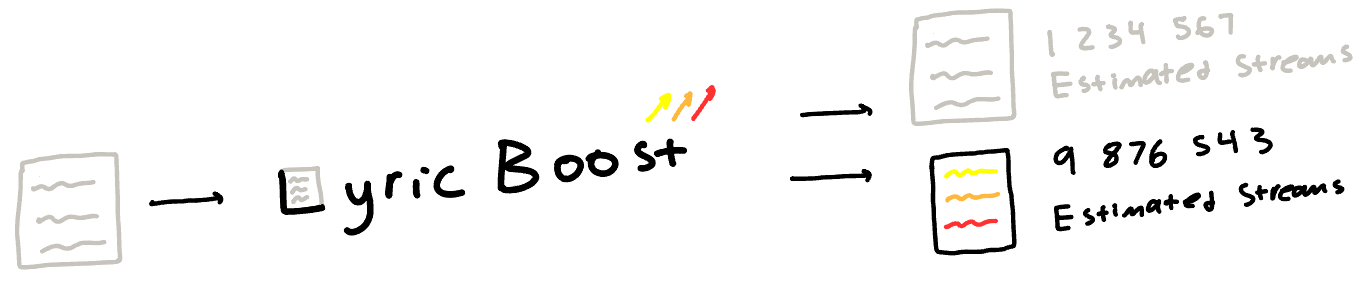

---

What factors might we consider when analyzing how lyrics connect to popularity?

- Frequently occuring n-grams
- Age of words (quantifying usage of words that more popular in the language at the time)
- Pronoun usage
- Subjects of songs (girl, man, etc)
- Word groupings (similar meanings)
- Repetition patterns
- Topics or themes
- ...

---

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.util import ngrams
from collections import Counter
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import collections
from collections import Counter
from itertools import chain
from scipy.stats import ttest_ind
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string
import matplotlib.pyplot as plt
import gensim.downloader as api
import spacy

/Users/theobragstad/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Getting popular song lyrics

In [33]:
url = 'https://kworb.net/spotify/songs.html'

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table', class_='addpos')

rows = table.find_all('tr')

songs = []

for row in rows[1:]: 
    artist_title_cell = row.find('td', class_='text').find('div')
    artist_title = artist_title_cell.text.strip()
    
    last_hyphen_index = artist_title.rfind(' - ')
    artist = artist_title[:last_hyphen_index]
    title = artist_title[last_hyphen_index + 3:]

    streams = row.find('td', class_='text').find_next_sibling().text.strip().replace(',', '')

    song_info = {
        "Title": title,
        "Artist": artist,
        "Streams": streams,
        "Lyrics": None
    }

    songs.append(song_info)

for song in songs:
    print(song)


{'Title': 'Blinding Lights', 'Artist': 'The Weeknd', 'Streams': '4180109021', 'Lyrics': None}
{'Title': 'Shape of You', 'Artist': 'Ed Sheeran', 'Streams': '3847842693', 'Lyrics': None}
{'Title': 'Someone You Loved', 'Artist': 'Lewis Capaldi', 'Streams': '3327180680', 'Lyrics': None}
{'Title': 'Sunflower', 'Artist': 'Post Malone', 'Streams': '3261697225', 'Lyrics': None}
{'Title': 'Starboy', 'Artist': 'The Weeknd', 'Streams': '3176252459', 'Lyrics': None}
{'Title': 'As It Was', 'Artist': 'Harry Styles', 'Streams': '3146314406', 'Lyrics': None}
{'Title': 'One Dance', 'Artist': 'Drake', 'Streams': '3097743498', 'Lyrics': None}
{'Title': 'Dance Monkey', 'Artist': 'Tones And I', 'Streams': '3029976995', 'Lyrics': None}
{'Title': 'STAY', 'Artist': 'The Kid LAROI', 'Streams': '3024564919', 'Lyrics': None}
{'Title': 'Believer', 'Artist': 'Imagine Dragons', 'Streams': '2930613523', 'Lyrics': None}
{'Title': 'rockstar', 'Artist': 'Post Malone', 'Streams': '2920414748', 'Lyrics': None}
{'Title': 

---

In [34]:
lyrics_df = pd.read_csv('lyrics.csv')

In [35]:
def format_name(link):
    if isinstance(link, str): 
        link = link.strip('/')
        parts = link.split('-')
        formatted_name = ' '.join(part.capitalize() for part in parts)
        return formatted_name
    else:
        return link

lyrics_df['Artist'] = lyrics_df['ALink'].apply(lambda x: format_name(x))
lyrics_df.drop(columns=['ALink', 'SLink', 'language'], inplace=True)
lyrics_df.rename(columns={'SName': 'Title', 'Lyric': 'Lyrics'}, inplace=True)


In [36]:
for song in songs:
    matching_row = lyrics_df[(lyrics_df['Title'] == song['Title']) & (lyrics_df['Artist'] == song['Artist'])]
    if not matching_row.empty:
        song['Lyrics'] = matching_row.iloc[0]['Lyrics']

for song in songs:
    print(song)

{'Title': 'Blinding Lights', 'Artist': 'The Weeknd', 'Streams': '4180109021', 'Lyrics': None}
{'Title': 'Shape of You', 'Artist': 'Ed Sheeran', 'Streams': '3847842693', 'Lyrics': None}
{'Title': 'Someone You Loved', 'Artist': 'Lewis Capaldi', 'Streams': '3327180680', 'Lyrics': None}
{'Title': 'Sunflower', 'Artist': 'Post Malone', 'Streams': '3261697225', 'Lyrics': None}
{'Title': 'Starboy', 'Artist': 'The Weeknd', 'Streams': '3176252459', 'Lyrics': None}
{'Title': 'As It Was', 'Artist': 'Harry Styles', 'Streams': '3146314406', 'Lyrics': None}
{'Title': 'One Dance', 'Artist': 'Drake', 'Streams': '3097743498', 'Lyrics': "[Intro: Kyla Wizkid]\nBaby I like your style\n\n[Verse 1: Drake]\nGrips on your waist\nFront way, back way\nYou know that I don't play\nStreets not safe\nBut I never run away\nEven when I'm away\nOti, oti, there's never much love when we go Ot\nI pray to make it back in one piece\nI pray, I pray\n\n[Hook: Drake]\nThat's why I need a one dance\nGot a Hennessy in my hand\n

In [38]:
missing_lyrics = sum(1 for song in songs if not song['Lyrics'])
have_lyrics = len(songs) - missing_lyrics

print(have_lyrics)
print(missing_lyrics)

718
1782


In [39]:
def scrape_lyrics(url):
    response = requests.get(url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        lyrics_div = soup.find('div', {'data-lyrics-container': 'true'})
        if lyrics_div:
            lyrics = lyrics_div.get_text(separator='\n')
            return lyrics.strip()  
        else:
            return None
    else:
        return None    

In [42]:
for song in songs:
    if not song['Lyrics']: 
        artist = "-".join(song['Artist'].split())
        title = "-".join(song['Title'].split()) 
        url = f"https://genius.com/{artist}-{title}-lyrics"
        song['Lyrics'] = scrape_lyrics(url)


In [44]:
missing_lyrics = sum(1 for song in songs if not song['Lyrics'])
have_lyrics = len(songs) - missing_lyrics

print(have_lyrics)
print(missing_lyrics)

1919
581


In [45]:
songs

[{'Title': 'Blinding Lights',
  'Artist': 'The Weeknd',
  'Streams': '4180109021',
  'Lyrics': "[Intro]\nYeah\n[Verse 1]\nI've been tryna call\nI've been on my own for long enough\nMaybe you can show me\u2005how\u2005to love, maybe\nI'm\u2005goin' through withdrawals\nYou don't even have\u2005to do too much\nYou can turn me on with just a touch, baby\n[Pre-Chorus]\nI look around and\nSin City's cold and empty (Oh)\nNo one's around to judge me (Oh)\nI can't see clearly when you're gone\n[Chorus]\nI said, ooh, I'm blinded by the lights\nNo, I can't sleep until I feel your touch\nI said, ooh, I'm drowning in the night\nOh, when I'm like this, you're the one I trust\nHey, hey, hey\n[Verse 2]\nI'm running out of time\n'Cause I can see the sun light up the sky\nSo I hit the road in overdrive, baby, oh"},
 {'Title': 'Shape of You',
  'Artist': 'Ed Sheeran',
  'Streams': '3847842693',
  'Lyrics': '[Verse 1]\nA club isn\'t the best place to find a lover\nSo the bar is where I go (Mm)\nMe and my

 .

In [80]:
missing_lyrics = sum(1 for song in songs if not song['Lyrics'])
have_lyrics = len(songs) - missing_lyrics

print(have_lyrics)
print(missing_lyrics)

1919
581


---

In [56]:
with open('songs.json', 'w') as f:
    json.dump(songs_with_lyrics, f)

In [89]:
def clean_lyrics(lyrics):
    lyrics = str(lyrics)
    
    lyrics = lyrics.replace('\'', '')
            
    lyrics = re.sub(r'[\*\[|\(|\{].*\n*.*[\]\)\}\*]' , ' ', lyrics)
   
    for verse in ['verse', 'VERSE', 'Verse']:
        lyrics = re.sub(verse+' \d*', '', lyrics)
    
    for word in ['OUTRO', 'INSTRUMENTAL', 'PRE', 'HOOK',
                 'PRODUCED', 'REFRAIN', 'POST', 'REPEAT', '2x', '3x', '4x',
                 'CHORUS', 'INTRO', 'INTERLUDE']:
        lyrics = lyrics.replace(word, '')
        
    lyrics = re.sub(r'\n*Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'^Chorus:*.*' , ' ', lyrics)
    lyrics = re.sub(r'\nRepeat [C|c]horus:*.*' , ' ', lyrics)
    
    lyrics = re.sub(r'Intro[\s|\n|:].*', ' ', lyrics)
    
    lyrics = re.sub(r'-+.*[i|I]nstrumental.*-+', ' ', lyrics)
    lyrics = re.sub(r'\nBrief instrumental.*\n', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental break', ' ', lyrics)
    lyrics = re.sub(r'\nInstrumental--', ' ', lyrics)
    lyrics = re.sub(r'\n~Instrumental~', ' ', lyrics)
    
    lyrics = re.sub(r'\n\[*Bridge:\[*', ' ', lyrics)
    
    lyrics = re.sub(r'Hook:.*', ' ', lyrics)
    
    lyrics = re.sub(r'Repeat\s.*', ' ', lyrics)
    lyrics = re.sub(r'\nRepeat$', ' ', lyrics)
    
    lyrics = re.sub(r'.*[P|p]roduced [B|b]y.*', ' ', lyrics)
    lyrics = re.sub(r'.*[W|w]ritten [B|b]y.*', ' ', lyrics)
    lyrics = re.sub(r'- musical interlude -', ' ', lyrics)
    lyrics = re.sub(r'\nRefrain:', ' ', lyrics)
            
    lyrics = re.sub(r'[^\w\s]', ' ', lyrics)
            
    lyrics = re.sub(r'\s+', ' ', lyrics)
    
    lyrics = lyrics.strip()
    
    lyrics = lyrics.lower()
    
    lyrics = re.sub(r'\s{2,}', ' ', lyrics)

    return lyrics

In [82]:
with open('songs.json', 'r') as f:
    data = json.load(f)

print(data)

[{'Title': 'Blinding Lights', 'Artist': 'The Weeknd', 'Streams': '4180109021', 'Lyrics': "[Intro]\nYeah\n[Verse 1]\nI've been tryna call\nI've been on my own for long enough\nMaybe you can show me\u2005how\u2005to love, maybe\nI'm\u2005goin' through withdrawals\nYou don't even have\u2005to do too much\nYou can turn me on with just a touch, baby\n[Pre-Chorus]\nI look around and\nSin City's cold and empty (Oh)\nNo one's around to judge me (Oh)\nI can't see clearly when you're gone\n[Chorus]\nI said, ooh, I'm blinded by the lights\nNo, I can't sleep until I feel your touch\nI said, ooh, I'm drowning in the night\nOh, when I'm like this, you're the one I trust\nHey, hey, hey\n[Verse 2]\nI'm running out of time\n'Cause I can see the sun light up the sky\nSo I hit the road in overdrive, baby, oh"}, {'Title': 'Shape of You', 'Artist': 'Ed Sheeran', 'Streams': '3847842693', 'Lyrics': '[Verse 1]\nA club isn\'t the best place to find a lover\nSo the bar is where I go (Mm)\nMe and my friends at t

In [90]:
songs_clean_lyrics = data.copy()

for song in songs_clean_lyrics:
    song['Lyrics'] = clean_lyrics(song['Lyrics'])


In [91]:
songs_clean_lyrics

[{'Title': 'Blinding Lights',
  'Artist': 'The Weeknd',
  'Streams': '4180109021',
  'Lyrics': 'yeah ive been tryna call ive been on my own for long enough maybe you can show me how to love maybe im goin through withdrawals you dont even have to do too much you can turn me on with just a touch baby i look around and sin citys cold and empty i cant see clearly when youre gone i said ooh im blinded by the lights no i cant sleep until i feel your touch i said ooh im drowning in the night oh when im like this youre the one i trust hey hey hey im running out of time cause i can see the sun light up the sky so i hit the road in overdrive baby oh'},
 {'Title': 'Shape of You',
  'Artist': 'Ed Sheeran',
  'Streams': '3847842693',
  'Lyrics': 'a club isnt the best place to find a lover so the bar is where i go me and my friends at the table doin shots drinkin fast and then we talk slow and you come over and start up a conversation with just me and trust me ill give it a chance now take my hand s

In [92]:
with open('songs_clean.json', 'w') as f:
    json.dump(songs_clean_lyrics, f)

In [177]:
df_popular = pd.DataFrame(songs_clean_lyrics)
df_popular

Title            Artist     Streams  \
0       Blinding Lights        The Weeknd  4180109021   
1          Shape of You        Ed Sheeran  3847842693   
2     Someone You Loved     Lewis Capaldi  3327180680   
3             Sunflower       Post Malone  3261697225   
4               Starboy        The Weeknd  3176252459   
...                 ...               ...         ...   
1914             Hey DJ              CNCO   458074267   
1915  my tears ricochet      Taylor Swift   457842866   
1916         Experience  Ludovico Einaudi   457814542   
1917           Sick Boy  The Chainsmokers   457768584   
1918  Forever After All        Luke Combs   457670455   

                                                 Lyrics  
0     yeah ive been tryna call ive been on my own fo...  
1     a club isnt the best place to find a lover so ...  
2     im going under and this time i fear theres no ...  
3     ayy ayy ayy ayy ayy ayy ooh ooh ooh ooh needle...  
4     ayy im tryna put you in the worst mood ah p1 c...  
...                                                 ...  
1914  cnco verso 1 yandel zabdiel de jesús soy yo el...  
1915  we gather here we line up weepin in a sunlit r...  
1916  you know the fire is running low can you feel ...  
1917  im from the east side of america where we choo...  
1918  a cold beers got twelve ounces a good trucks g...  

[1919 rows x 4 columns]

In [184]:
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown' 

df_popular['Language'] = df_popular['Lyrics'].apply(detect_language)

df_popular = df_popular[df_popular['Language'] == 'en']

In [204]:
df_popular.drop(columns=['Language'], inplace=True)

/var/folders/lg/dk9tt69935gcdz1c_wb40mnr0000gn/T/ipykernel_88269/1845514035.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popular.drop(columns=['Language'], inplace=True)


In [311]:
df_popular = df_popular[['Title', 'Artist', 'Lyrics', 'Streams']]
df_popular

Title  \
0                                       Blinding Lights   
1                                          Shape of You   
2                                     Someone You Loved   
3                                             Sunflower   
4                                               Starboy   
5                                             As It Was   
6                                             One Dance   
7                                          Dance Monkey   
8                                                  STAY   
9                                              Believer   
10                                             rockstar   
11                                           Heat Waves   
12                                              Perfect   
13                                               Closer   
14                                      Sweater Weather   
15                                 Say You Won't Let Go   
16                                               lovely   
17                                     Watermelon Sugar   
18                             Something Just Like This   
19                                         Lucid Dreams   
20                                           God's Plan   
21                                              bad guy   
22                                           Photograph   
23                                    Thinking out Loud   
24                                    Take Me to Church   
25                                              Riptide   
26                                    Bohemian Rhapsody   
27                                              Circles   
28                                              Shallow   
29                                       Counting Stars   
30                                        Love Yourself   
31                                         Another Love   
32                                              Thunder   
33                                            All of Me   
34                                           goosebumps   
35                                         Stressed Out   
36                                           Wake Me Up   
37                                            The Hills   
38                                              7 rings   
39                                               Yellow   
40                                           Let Her Go   
41                                               Demons   
42                                          Die For You   
43                                              HUMBLE.   
44                                       Jocelyn Flores   
45                                        Lose Yourself   
46                                      drivers license   
47                                     Do I Wanna Know?   
48                                             One Kiss   
49                                             good 4 u   
50                                     Treat You Better   
51                                       Mr. Brightside   
52                                           SICKO MODE   
53                                      Let Me Love You   
54                                        XO Tour Llif3   
55                                           Without Me   
56                                            New Rules   
57                                                Sorry   
58                                         Stay With Me   
59                                               Havana   
60                                     I Wanna Be Yours   
61                                  When I Was Your Man   
62                                           Levitating   
63                                              Lean On   
64                                         Viva La Vida   
65                                 Too Good At Goodbyes   
66                                   That's What I Like   
67                                 Jus

In [321]:
df_popular.dtypes

Title      object
Artist     object
Lyrics     object
Streams    object
dtype: object

In [322]:
df_popular

Title            Artist  \
0       Blinding Lights        The Weeknd   
1          Shape of You        Ed Sheeran   
2     Someone You Loved     Lewis Capaldi   
3             Sunflower       Post Malone   
4               Starboy        The Weeknd   
...                 ...               ...   
1913            Kiss Me        Ed Sheeran   
1915  my tears ricochet      Taylor Swift   
1916         Experience  Ludovico Einaudi   
1917           Sick Boy  The Chainsmokers   
1918  Forever After All        Luke Combs   

                                                 Lyrics     Streams  
0     yeah ive been tryna call ive been on my own fo...  4180109021  
1     a club isnt the best place to find a lover so ...  3847842693  
2     im going under and this time i fear theres no ...  3327180680  
3     ayy ayy ayy ayy ayy ayy ooh ooh ooh ooh needle...  3261697225  
4     ayy im tryna put you in the worst mood ah p1 c...  3176252459  
...                                                 ...         ...  
1913  settle down with me cover me up cuddle me in l...   458178871  
1915  we gather here we line up weepin in a sunlit r...   457842866  
1916  you know the fire is running low can you feel ...   457814542  
1917  im from the east side of america where we choo...   457768584  
1918  a cold beers got twelve ounces a good trucks g...   457670455  

[1727 rows x 4 columns]

In [327]:
df_popular['Streams'] = pd.to_numeric(df_popular['Streams'], errors='coerce')

df_popular_sorted = df_popular.sort_values(by='Streams', ascending=False)

df_unique = df_popular_sorted.drop_duplicates(subset=['Title', 'Artist'], keep='first')

df_popular = df_unique
df_popular

/var/folders/lg/dk9tt69935gcdz1c_wb40mnr0000gn/T/ipykernel_88269/2823402301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popular['Streams'] = pd.to_numeric(df_popular['Streams'], errors='coerce')


Title            Artist  \
0       Blinding Lights        The Weeknd   
1          Shape of You        Ed Sheeran   
2     Someone You Loved     Lewis Capaldi   
3             Sunflower       Post Malone   
4               Starboy        The Weeknd   
...                 ...               ...   
1913            Kiss Me        Ed Sheeran   
1915  my tears ricochet      Taylor Swift   
1916         Experience  Ludovico Einaudi   
1917           Sick Boy  The Chainsmokers   
1918  Forever After All        Luke Combs   

                                                 Lyrics     Streams  
0     yeah ive been tryna call ive been on my own fo...  4180109021  
1     a club isnt the best place to find a lover so ...  3847842693  
2     im going under and this time i fear theres no ...  3327180680  
3     ayy ayy ayy ayy ayy ayy ooh ooh ooh ooh needle...  3261697225  
4     ayy im tryna put you in the worst mood ah p1 c...  3176252459  
...                                                 ...         ...  
1913  settle down with me cover me up cuddle me in l...   458178871  
1915  we gather here we line up weepin in a sunlit r...   457842866  
1916  you know the fire is running low can you feel ...   457814542  
1917  im from the east side of america where we choo...   457768584  
1918  a cold beers got twelve ounces a good trucks g...   457670455  

[1715 rows x 4 columns]

---

.

## Getting less popular song lyrics

In [328]:
n = len(df_popular)
n

1715

In [239]:
spotify_songs = pd.read_csv('spotify_songs.csv')

In [240]:
spotify_songs = spotify_songs.sort_values(by='track_popularity', ascending=True)

In [241]:
spotify_songs.info

<bound method DataFrame.info of                      track_id                                     track_name  \
9712   46xnw9xZ0gKsGqaKg6jAzu                          Crucial - Dance Remix   
13009  5l43cvpvx3zpInfzD6j2UL                             It's In The Mornin   
7009   2yX2u7VsiaYJPncqwcmyur  Me Against The World - Album Version (Edited)   
7012   2YXYKrW2HtvLIVCMD3eXXj                                    James Joint   
15894  6RsnwfOHuNfYw1vMZbAy8l                                          Choca   
...                       ...                                            ...   
4813   21jGcNKet2qwijlDFuPiPb                                        Circles   
1375   0nbXyq5TXYPCO7pr3N8S4I                                        The Box   
5221   2b8fOow8UzyDFAE27YhOZM                                       Memories   
14477  696DnlkuDOXcMAnKlTgXXK                                        ROXANNE   
6925   2XU0oxnq2qxCpomAAuJY8K                                   Dance Monkey   

       

In [242]:
spotify_songs = spotify_songs[spotify_songs['track_popularity'] <= 2]
spotify_songs = spotify_songs[spotify_songs['language'] == 'en']

In [243]:
spotify_songs = spotify_songs[['track_name', 
                               'track_artist', 
                               'lyrics', 
                               'track_popularity']] 

In [244]:
spotify_songs.rename(columns={'track_name': 'Title',
                              'track_artist': 'Artist',
                              'lyrics': 'Lyrics',
                              'track_popularity': 'Popularity'}, inplace=True)

In [245]:
spotify_songs

Title  \
9712                           Crucial - Dance Remix   
13009                             It's In The Mornin   
7009   Me Against The World - Album Version (Edited)   
7012                                     James Joint   
5499                                    Wasted Words   
...                                              ...   
37                                      Been A While   
3928                          I Found U - Radio Edit   
6000                              Crazy Crazy Nights   
9139                        Blind Heart - Radio Edit   
666                                      Black betty   

                         Artist  \
9712                New Edition   
13009              Robin Thicke   
7009                       2Pac   
7012                    Rihanna   
5499   The Allman Brothers Band   
...                         ...   
37                    Sam Feldt   
3928                     Axwell   
6000                       KISS   
9139                   CAZZETTE   
666                     Ram Jam   

                                                  Lyrics  Popularity  
9712   Heart, beating strong I was serious My love wa...           0  
13009  I'm in the mood for lovin' We'll be touchin, W...           0  
7009   It's just me against the world Nothin' to lose...           0  
7012   I'd rather be smoking weed whenever we breathe...           0  
5499   Can you tell me, tell me, friend, just exactly...           0  
...                                                  ...         ...  
37     It's been a while Since I let you Cross my min...           2  
3928   Everybody wanna know Why I'm walking round wit...           2  
6000   Whoow! Here's a little song for everybody out ...           2  
9139   You got me strung up like a puppet, Hung up on...           2  
666    NA Whoa, Black Betty (bam-ba-lam) Whoa, Black ...           2  

[1907 rows x 4 columns]

In [332]:
spotify_songs = spotify_songs.drop_duplicates(subset=['Title', 'Artist'], keep='first')


In [255]:
spotify_songs['Lyrics'] = spotify_songs['Lyrics'].apply(clean_lyrics)

In [333]:
less_popular_sample = spotify_songs.sample(n)
df_not_popular = less_popular_sample.copy()
df_not_popular

Title                        Artist  \
2375                        Silky Soul                          Maze   
14019                    My Gun Go Off                       50 Cent   
13426                  Bookoo Bread Co                Scallops Hotel   
14464             Get It Shawty - Main                         Lloyd   
4296                            Echoes                         Camel   
...                                ...                           ...   
17269                         Backwood                    Ari Lennox   
5262                   Bad Moon Rising  Creedence Clearwater Revival   
10656  Dreamer - Matisse & Sadko Remix            Axwell /\ Ingrosso   
8306                       Born To Run                      Afrojack   
18226                            Waves                        Perttu   

                                                  Lyrics  Popularity  
2375   there was a man i knew who was smooth as smoot...           0  
14019  na nigga my gun go off you see the barrel turn...           0  
13426  im wearing jazz musician socks padded shoulder...           0  
14464  i guess if i can let this moment slip away cau...           1  
4296   out of the mist rising ten thousand navajo bra...           0  
...                                                  ...         ...  
17269  said papa gon roll one for me he gon get me li...           0  
5262   i see the bad moon arising i see trouble on th...           0  
10656  heavy on your heart heavy on your mind wanderi...           2  
8306   im in way over my head cant find the sunset ov...           0  
18226  feel the chills run down your spine down to yo...           1  

[1715 rows x 4 columns]

---

## What now

Now we have `df_popular` and `df_not_popular`.
We want to see what makes the lyrics in `df_popular` have high stream counts and what makes the lyrics in `df_not_popular` have lower popularity, a metric that often tends to correlate to low stream counts (at least for newly released songs).

Note: popularity is a Spotify metric that ranges from 0-100.

Predicting a range of stream counts for a given set of input lyrics has turned out to be too ambitous of a goal for the scope of this project. It would require a much larger dataset with lyrics and well-distributed stream counts across a wide range of stream counts, such as 0-1B or some tiered set of ranges like 0-1M, 1-5M, 5-10M, 10-50M, 50-100M, 100-500M, 500M-1B, and 1B+. Such a dataset does not exist to our knowledge and would be very tedious to create. For example, the process of getting songs with streams in the range of 0-1M is nearly impossible to streamline because no lists or resources exist for songs in this range and no APIs offer such a feature, so it would require essentially random guessing and repeated API requests/web scraping.

This is why for the non-popular songs we do not have stream counts. The Spotify API does not provide access to stream counts, and lists do not exist online for songs with low popularity/stream counts.

We will focus instead on seeing what differentiates the lyrics of very popular songs compared to songs that are not popular at all.

---

### Ngrams

In [336]:
nltk.download('punkt')
df_popular['Tokens'] = df_popular['Lyrics'].apply(lambda x: [] if pd.isna(x) else word_tokenize(x))
df_not_popular['Tokens'] = df_not_popular['Lyrics'].apply(lambda x: [] if pd.isna(x) else word_tokenize(x))

def calculate_ngrams(tokens, n):
    n_grams = Counter(ngrams(tokens, n))
    return n_grams.most_common(10)



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/theobragstad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/lg/dk9tt69935gcdz1c_wb40mnr0000gn/T/ipykernel_88269/1400910453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popular['Tokens'] = df_popular['Lyrics'].apply(lambda x: [] if pd.isna(x) else word_tokenize(x))


In [337]:
popular_ngrams = {}
for i in range(1, 11):
    popular_ngrams[i] = calculate_ngrams(df_popular['Tokens'].explode(), i)

not_popular_ngrams = {}
for i in range(1, 11):
    not_popular_ngrams[i] = calculate_ngrams(df_not_popular['Tokens'].explode(), i)

In [338]:
popular_ngrams

{1: [(('i',), 16626),
  (('you',), 15554),
  (('the',), 12653),
  (('me',), 7817),
  (('and',), 7768),
  (('to',), 7496),
  (('a',), 7246),
  (('my',), 6443),
  (('it',), 5902),
  (('in',), 4839)],
 2: [(('in', 'the'), 1561),
  (('wan', 'na'), 1273),
  (('and', 'i'), 1170),
  (('i', 'dont'), 1026),
  (('i', 'know'), 941),
  (('oh', 'oh'), 896),
  (('you', 'know'), 794),
  (('on', 'the'), 725),
  (('gon', 'na'), 721),
  (('i', 'got'), 708)],
 3: [(('oh', 'oh', 'oh'), 574),
  (('i', 'wan', 'na'), 396),
  (('la', 'la', 'la'), 323),
  (('ooh', 'ooh', 'ooh'), 292),
  (('na', 'na', 'na'), 290),
  (('yeah', 'yeah', 'yeah'), 270),
  (('wan', 'na', 'be'), 237),
  (('dont', 'wan', 'na'), 207),
  (('you', 'and', 'i'), 179),
  (('i', 'dont', 'know'), 163)],
 4: [(('oh', 'oh', 'oh', 'oh'), 372),
  (('la', 'la', 'la', 'la'), 258),
  (('na', 'na', 'na', 'na'), 242),
  (('ooh', 'ooh', 'ooh', 'ooh'), 229),
  (('yeah', 'yeah', 'yeah', 'yeah'), 160),
  (('i', 'dont', 'wan', 'na'), 145),
  (('i', 'just', 

In [339]:
not_popular_ngrams

{1: [(('you',), 16044),
  (('the',), 15534),
  (('i',), 15423),
  (('to',), 8816),
  (('me',), 8448),
  (('and',), 8293),
  (('a',), 7846),
  (('my',), 6424),
  (('it',), 6396),
  (('in',), 5471)],
 2: [(('in', 'the'), 1833),
  (('wan', 'na'), 1150),
  (('i', 'dont'), 982),
  (('oh', 'oh'), 977),
  (('you', 'know'), 935),
  (('and', 'i'), 915),
  (('on', 'the'), 884),
  (('i', 'know'), 802),
  (('to', 'the'), 728),
  (('i', 'can'), 694)],
 3: [(('oh', 'oh', 'oh'), 620),
  (('i', 'wan', 'na'), 423),
  (('yeah', 'yeah', 'yeah'), 341),
  (('me', 'me', 'me'), 338),
  (('la', 'la', 'la'), 232),
  (('dont', 'wan', 'na'), 219),
  (('i', 'dont', 'know'), 209),
  (('ooh', 'ooh', 'ooh'), 176),
  (('you', 'wan', 'na'), 173),
  (('i', 'dont', 'wan'), 165)],
 4: [(('oh', 'oh', 'oh', 'oh'), 434),
  (('me', 'me', 'me', 'me'), 297),
  (('yeah', 'yeah', 'yeah', 'yeah'), 236),
  (('la', 'la', 'la', 'la'), 190),
  (('i', 'dont', 'wan', 'na'), 165),
  (('hey', 'hey', 'hey', 'hey'), 137),
  (('ooh', 'ooh',

In [413]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def tokenize_without_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    return tokens

df_popular['Tokens'] = df_popular['Lyrics'].apply(lambda x: [] if pd.isna(x) else tokenize_without_stopwords(x))
df_not_popular['Tokens'] = df_not_popular['Lyrics'].apply(lambda x: [] if pd.isna(x) else tokenize_without_stopwords(x))

def calculate_ngrams(tokens, n):
    n_grams = Counter(zip(*[tokens[i:] for i in range(n)]))
    return n_grams.most_common(10)

popular_ngrams = {}
for i in range(1, 11):
    popular_ngrams[i] = calculate_ngrams(list(chain.from_iterable(df_popular['Tokens'].values)), i)

not_popular_ngrams = {}
for i in range(1, 11):
    not_popular_ngrams[i] = calculate_ngrams(list(chain.from_iterable(df_not_popular['Tokens'].values)), i)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theobragstad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/var/folders/lg/dk9tt69935gcdz1c_wb40mnr0000gn/T/ipykernel_88269/442291983.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popular['Tokens'] = df_popular['Lyrics'].apply(lambda x: [] if pd.isna(x) else tokenize_without_stopwords(x))


In [414]:
popular_ngrams

{1: [(('im',), 4638),
  (('like',), 3260),
  (('dont',), 3057),
  (('know',), 2877),
  (('oh',), 2623),
  (('got',), 2513),
  (('love',), 2496),
  (('na',), 2409),
  (('yeah',), 2277),
  (('get',), 1634)],
 2: [(('wan', 'na'), 1273),
  (('oh', 'oh'), 932),
  (('gon', 'na'), 721),
  (('yeah', 'yeah'), 494),
  (('ooh', 'ooh'), 465),
  (('got', 'ta'), 419),
  (('la', 'la'), 404),
  (('dont', 'know'), 353),
  (('na', 'na'), 351),
  (('let', 'go'), 231)],
 3: [(('oh', 'oh', 'oh'), 594),
  (('ooh', 'ooh', 'ooh'), 352),
  (('la', 'la', 'la'), 323),
  (('na', 'na', 'na'), 290),
  (('yeah', 'yeah', 'yeah'), 272),
  (('dont', 'wan', 'na'), 212),
  (('im', 'gon', 'na'), 173),
  (('ah', 'ah', 'ah'), 119),
  (('doo', 'doo', 'doo'), 116),
  (('know', 'know', 'know'), 84)],
 4: [(('oh', 'oh', 'oh', 'oh'), 395),
  (('ooh', 'ooh', 'ooh', 'ooh'), 294),
  (('la', 'la', 'la', 'la'), 258),
  (('na', 'na', 'na', 'na'), 242),
  (('yeah', 'yeah', 'yeah', 'yeah'), 160),
  (('doo', 'doo', 'doo', 'doo'), 108),
 

In [415]:
not_popular_ngrams

{1: [(('im',), 4399),
  (('dont',), 3032),
  (('know',), 3006),
  (('like',), 2909),
  (('love',), 2901),
  (('oh',), 2702),
  (('got',), 2611),
  (('get',), 2271),
  (('na',), 2259),
  (('yeah',), 1906)],
 2: [(('wan', 'na'), 1150),
  (('oh', 'oh'), 1094),
  (('gon', 'na'), 679),
  (('yeah', 'yeah'), 553),
  (('dont', 'know'), 444),
  (('got', 'ta'), 434),
  (('let', 'go'), 304),
  (('la', 'la'), 281),
  (('ooh', 'ooh'), 268),
  (('hey', 'hey'), 245)],
 3: [(('oh', 'oh', 'oh'), 711),
  (('yeah', 'yeah', 'yeah'), 347),
  (('la', 'la', 'la'), 232),
  (('dont', 'wan', 'na'), 220),
  (('im', 'gon', 'na'), 184),
  (('ooh', 'ooh', 'ooh'), 176),
  (('hey', 'hey', 'hey'), 164),
  (('boom', 'boom', 'boom'), 151),
  (('dum', 'dum', 'dum'), 145),
  (('love', 'love', 'love'), 105)],
 4: [(('oh', 'oh', 'oh', 'oh'), 472),
  (('yeah', 'yeah', 'yeah', 'yeah'), 241),
  (('la', 'la', 'la', 'la'), 190),
  (('hey', 'hey', 'hey', 'hey'), 138),
  (('ooh', 'ooh', 'ooh', 'ooh'), 131),
  (('boom', 'boom', 'bo

In [416]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

similarity_scores = {}
for n in range(1, 11):
    popular_set = set([gram[0] for gram in popular_ngrams[n]])
    not_popular_set = set([gram[0] for gram in not_popular_ngrams[n]])
    similarity_scores[n] = jaccard_similarity(popular_set, not_popular_set)

for n, score in similarity_scores.items():
    print(f"Jaccard similarity for {n}-grams: {score}")


Jaccard similarity for 1-grams: 1.0
Jaccard similarity for 2-grams: 0.8181818181818182
Jaccard similarity for 3-grams: 0.42857142857142855
Jaccard similarity for 4-grams: 0.3333333333333333
Jaccard similarity for 5-grams: 0.3333333333333333
Jaccard similarity for 6-grams: 0.42857142857142855
Jaccard similarity for 7-grams: 0.42857142857142855
Jaccard similarity for 8-grams: 0.42857142857142855
Jaccard similarity for 9-grams: 0.3333333333333333
Jaccard similarity for 10-grams: 0.3333333333333333


In [471]:
for n, score in similarity_scores.items():
    print(f"{n}-grams: {round(score, 2)}")


1-grams: 1.0
2-grams: 0.82
3-grams: 0.43
4-grams: 0.33
5-grams: 0.33
6-grams: 0.43
7-grams: 0.43
8-grams: 0.43
9-grams: 0.33
10-grams: 0.33


## Ngram popularity trends

In [344]:
popular_lyrics = ' '.join(df_popular['Lyrics'])
nonpopular_lyrics = ' '.join(df_not_popular['Lyrics'])

popular_words = nltk.word_tokenize(popular_lyrics)
nonpopular_words = nltk.word_tokenize(nonpopular_lyrics)

stop_words = set(stopwords.words('english'))
popular_words = [word.lower() for word in popular_words if word.isalpha() and word.lower() not in stop_words]
nonpopular_words = [word.lower() for word in nonpopular_words if word.isalpha() and word.lower() not in stop_words]

popular_word_freq = Counter(popular_words)
nonpopular_word_freq = Counter(nonpopular_words)

---

## Pronoun usage

In [371]:
nlp = spacy.load("en_core_web_sm")

In [372]:
def count_pronouns(text):
    doc = nlp(text)
    pronoun_count = {'PRP': 0, 'PRP$': 0}  
    for token in doc:
        if token.pos_ == 'PRON' and token.tag_ in pronoun_count:
            pronoun_count[token.tag_] += 1
    return pronoun_count


pronoun_counts_popular = df_popular['Lyrics'].apply(count_pronouns)
pronoun_counts_not_popular = df_not_popular['Lyrics'].apply(count_pronouns)


In [373]:
pronoun_counts_popular

0        {'PRP': 23, 'PRP$': 2}
1       {'PRP': 22, 'PRP$': 13}
2        {'PRP': 32, 'PRP$': 6}
3        {'PRP': 25, 'PRP$': 5}
4        {'PRP': 17, 'PRP$': 8}
                 ...           
1913    {'PRP': 42, 'PRP$': 15}
1915    {'PRP': 61, 'PRP$': 12}
1916     {'PRP': 12, 'PRP$': 2}
1917    {'PRP': 78, 'PRP$': 12}
1918      {'PRP': 8, 'PRP$': 4}
Name: Lyrics, Length: 1715, dtype: object

In [374]:
pronoun_counts_not_popular

2375      {'PRP': 20, 'PRP$': 5}
14019    {'PRP': 78, 'PRP$': 35}
13426     {'PRP': 11, 'PRP$': 8}
14464    {'PRP': 82, 'PRP$': 12}
4296       {'PRP': 0, 'PRP$': 2}
                  ...           
17269     {'PRP': 28, 'PRP$': 4}
5262      {'PRP': 10, 'PRP$': 9}
10656     {'PRP': 69, 'PRP$': 9}
8306      {'PRP': 35, 'PRP$': 4}
18226     {'PRP': 47, 'PRP$': 8}
Name: Lyrics, Length: 1715, dtype: object

<AxesSubplot:title={'center':'Comparison of Pronoun Usage'}>

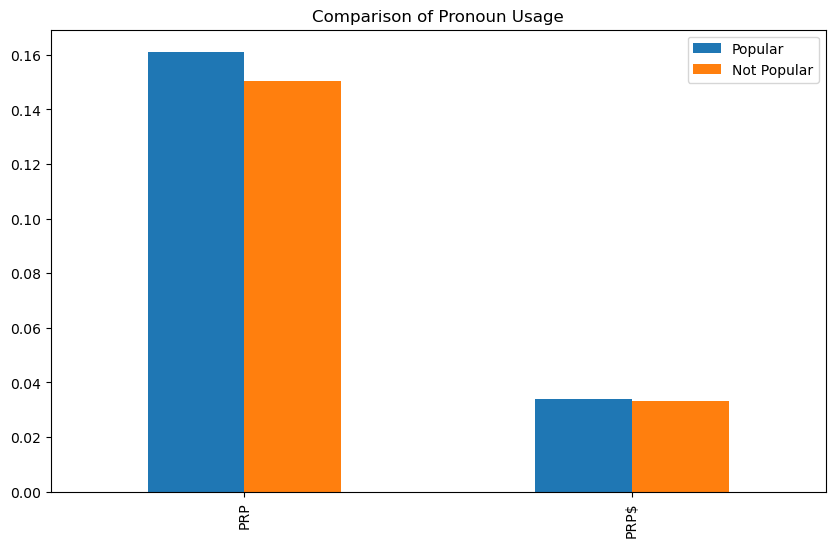

In [377]:
total_counts_popular = collections.Counter()
total_counts_not_popular = collections.Counter()

for counts in pronoun_counts_popular:
    total_counts_popular += counts

for counts in pronoun_counts_not_popular:
    total_counts_not_popular += counts

total_words_popular = df_popular['Lyrics'].apply(lambda x: len(x.split())).sum()
total_words_not_popular = df_not_popular['Lyrics'].apply(lambda x: len(x.split())).sum()

normalized_counts_popular = {k: v / total_words_popular for k, v in total_counts_popular.items()}
normalized_counts_not_popular = {k: v / total_words_not_popular for k, v in total_counts_not_popular.items()}

comparison_df = pd.DataFrame({
    'Popular': normalized_counts_popular,
    'Not Popular': normalized_counts_not_popular
})

comparison_df.plot(kind='bar', figsize=(10, 6), title='Comparison of Pronoun Usage')

<AxesSubplot:title={'center':'Comparison of Pronoun Usage'}>

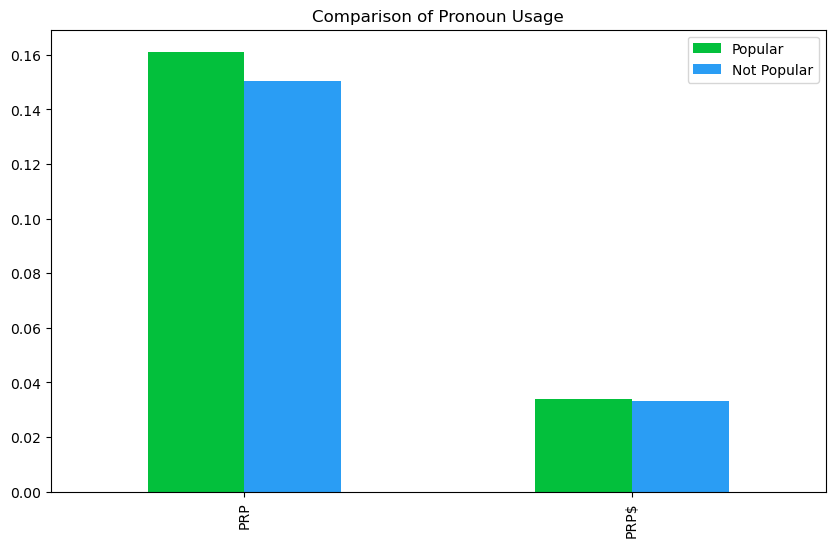

In [477]:
comparison_df.plot(kind='bar', figsize=(10, 6), title='Comparison of Pronoun Usage', color=['#03c03c', '#2A9DF4'])


---

In [381]:
def count_specific_pronouns(text):
    doc = nlp(text)
    pronoun_count = {
        'I': 0, 'me': 0, 'my': 0, 'mine': 0, 'myself': 0,
        'you': 0, 'your': 0, 'yours': 0, 'yourself': 0, 'yourselves': 0,
        'he': 0, 'him': 0, 'his': 0, 'himself': 0,
        'she': 0, 'her': 0, 'hers': 0, 'herself': 0,
        'it': 0, 'its': 0, 'itself': 0,
        'we': 0, 'us': 0, 'our': 0, 'ours': 0, 'ourselves': 0,
        'they': 0, 'them': 0, 'their': 0, 'theirs': 0, 'themselves': 0
    }  
    for token in doc:
        if token.text.lower() in pronoun_count:
            pronoun_count[token.text.lower()] += 1
    return pronoun_count


In [382]:
specific_counts_df_popular = collections.Counter()
specific_counts_df_not_popular = collections.Counter()

for index, row in df_popular.iterrows():
    pronoun_count = count_specific_pronouns(row['Lyrics'])
    specific_counts_df_popular += collections.Counter(pronoun_count)

for index, row in df_not_popular.iterrows():
    pronoun_count = count_specific_pronouns(row['Lyrics'])
    specific_counts_df_not_popular += collections.Counter(pronoun_count)

print("Counts of specific pronouns for df_popular:", specific_counts_df_popular)
print("Counts of specific pronouns for df_not_popular:", specific_counts_df_not_popular)

Counts of specific pronouns for df_popular: Counter({'you': 17817, 'me': 7701, 'my': 6443, 'it': 5953, 'your': 3437, 'we': 2981, 'its': 2309, 'she': 1615, 'they': 1536, 'her': 916, 'he': 869, 'us': 491, 'them': 425, 'our': 361, 'myself': 284, 'his': 273, 'him': 250, 'mine': 236, 'their': 130, 'yourself': 112, 'yours': 109, 'ourselves': 15, 'himself': 9, 'ours': 9, 'hers': 9, 'herself': 7, 'itself': 7, 'themselves': 3, 'theirs': 1})
Counts of specific pronouns for df_not_popular: Counter({'you': 18171, 'me': 8400, 'it': 6433, 'my': 6424, 'your': 3962, 'we': 3732, 'its': 2360, 'they': 1565, 'she': 1208, 'her': 865, 'he': 685, 'our': 573, 'us': 537, 'them': 494, 'his': 292, 'mine': 269, 'him': 267, 'myself': 207, 'yourself': 164, 'their': 164, 'yours': 77, 'ourselves': 21, 'ours': 11, 'themselves': 8, 'himself': 7, 'itself': 5, 'herself': 3, 'hers': 1})


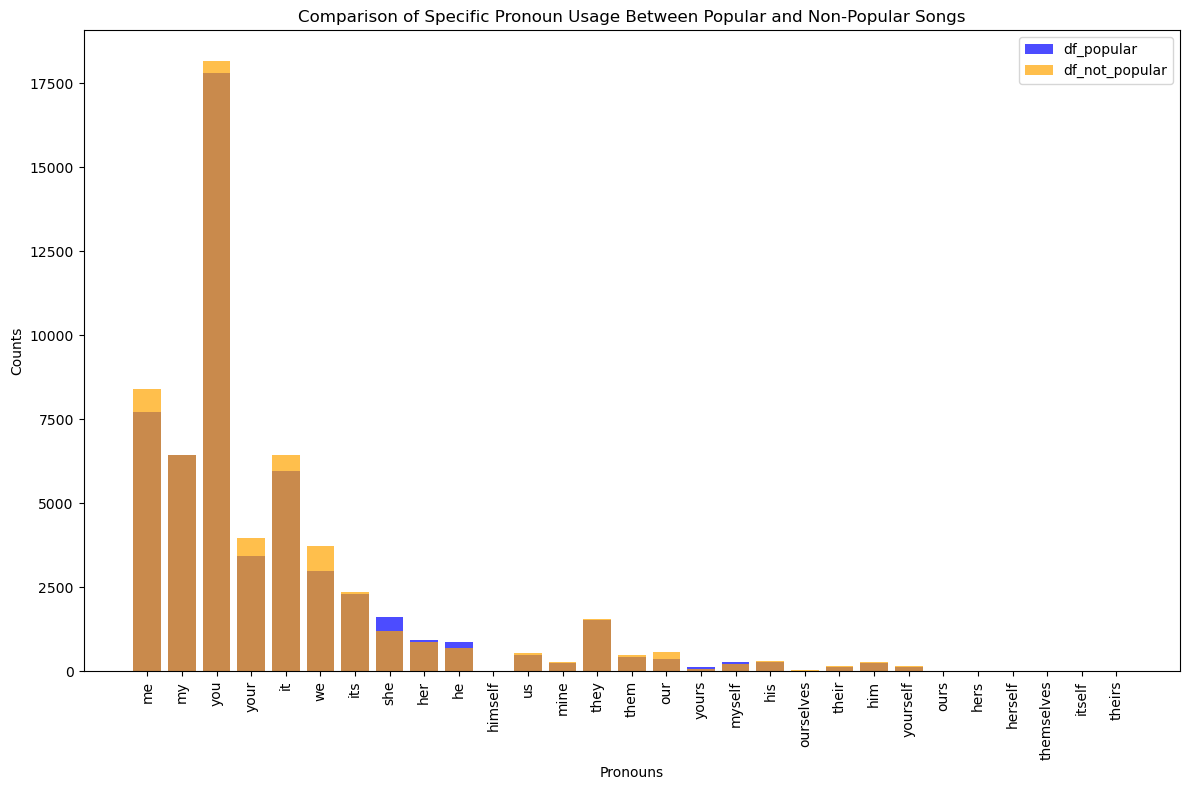

In [385]:
plt.figure(figsize=(12, 8))
plt.bar(specific_counts_df_popular.keys(), specific_counts_df_popular.values(), color='blue', alpha=0.7, label='df_popular')
plt.bar(specific_counts_df_not_popular.keys(), specific_counts_df_not_popular.values(), color='orange', alpha=0.7, label='df_not_popular')
plt.xlabel('Pronouns')
plt.ylabel('Counts')
plt.title('Comparison of Specific Pronoun Usage Between Popular and Non-Popular Songs')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

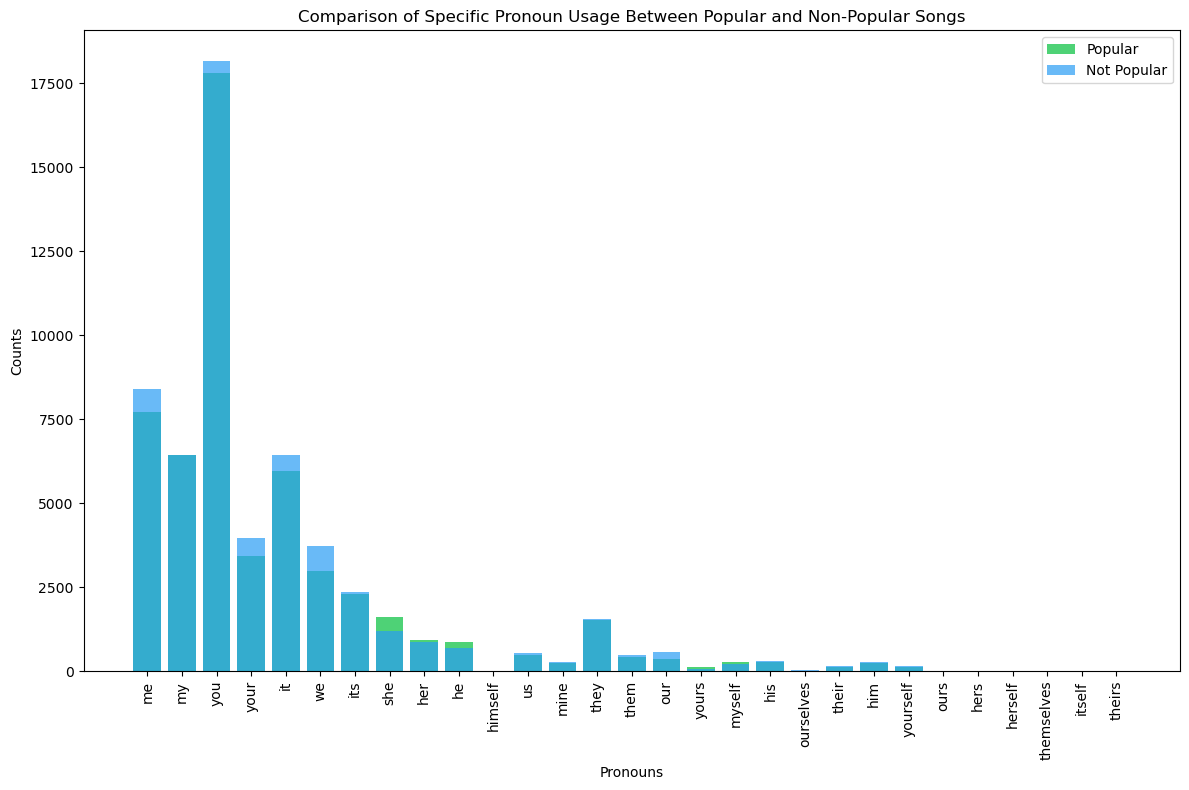

In [476]:
plt.figure(figsize=(12, 8))
plt.bar(specific_counts_df_popular.keys(), specific_counts_df_popular.values(), color='#03C03C', alpha=0.7, label='Popular')
plt.bar(specific_counts_df_not_popular.keys(), specific_counts_df_not_popular.values(), color='#2A9DF4', alpha=0.7, label='Not Popular')
plt.xlabel('Pronouns')
plt.ylabel('Counts')
plt.title('Comparison of Specific Pronoun Usage Between Popular and Non-Popular Songs')
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

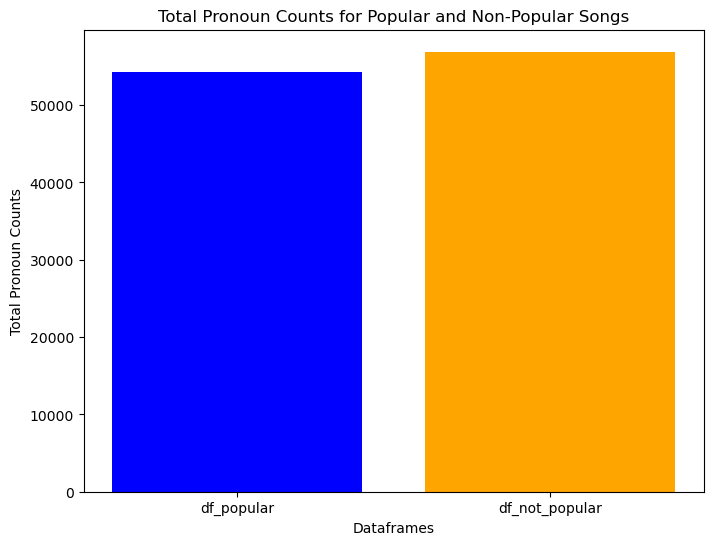

Total pronoun counts for df_popular: 54308
Total pronoun counts for df_not_popular: 56905


In [386]:
total_counts_df_popular = sum(specific_counts_df_popular.values())
total_counts_df_not_popular = sum(specific_counts_df_not_popular.values())

plt.figure(figsize=(8, 6))
plt.bar(['df_popular', 'df_not_popular'], [total_counts_df_popular, total_counts_df_not_popular], color=['blue', 'orange'])
plt.xlabel('Dataframes')
plt.ylabel('Total Pronoun Counts')
plt.title('Total Pronoun Counts for Popular and Non-Popular Songs')
plt.show()

print("Total pronoun counts for df_popular:", total_counts_df_popular)
print("Total pronoun counts for df_not_popular:", total_counts_df_not_popular)

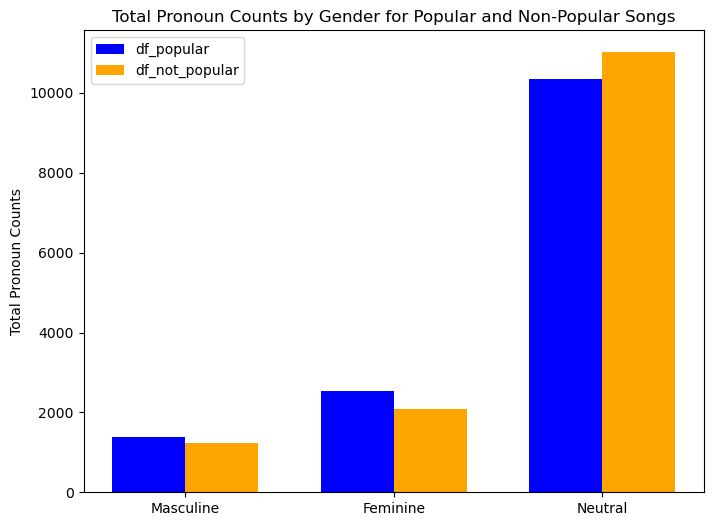

In [389]:
masculine_pronouns = ['he', 'him', 'his']
feminine_pronouns = ['she', 'her', 'hers']
neutral_pronouns = ['it', 'they', 'them', 'its', 'their', 'theirs']

masculine_count_popular = sum(specific_counts_df_popular[pronoun] for pronoun in masculine_pronouns)
feminine_count_popular = sum(specific_counts_df_popular[pronoun] for pronoun in feminine_pronouns)
neutral_count_popular = sum(specific_counts_df_popular[pronoun] for pronoun in neutral_pronouns)

masculine_count_not_popular = sum(specific_counts_df_not_popular[pronoun] for pronoun in masculine_pronouns)
feminine_count_not_popular = sum(specific_counts_df_not_popular[pronoun] for pronoun in feminine_pronouns)
neutral_count_not_popular = sum(specific_counts_df_not_popular[pronoun] for pronoun in neutral_pronouns)

labels = ['Masculine', 'Feminine', 'Neutral']
totals_popular = [masculine_count_popular, feminine_count_popular, neutral_count_popular]
totals_not_popular = [masculine_count_not_popular, feminine_count_not_popular, neutral_count_not_popular]

x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, totals_popular, width, label='df_popular', color='blue')
ax.bar([i + width for i in x], totals_not_popular, width, label='df_not_popular', color='orange')

ax.set_ylabel('Total Pronoun Counts')
ax.set_title('Total Pronoun Counts by Gender for Popular and Non-Popular Songs')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()


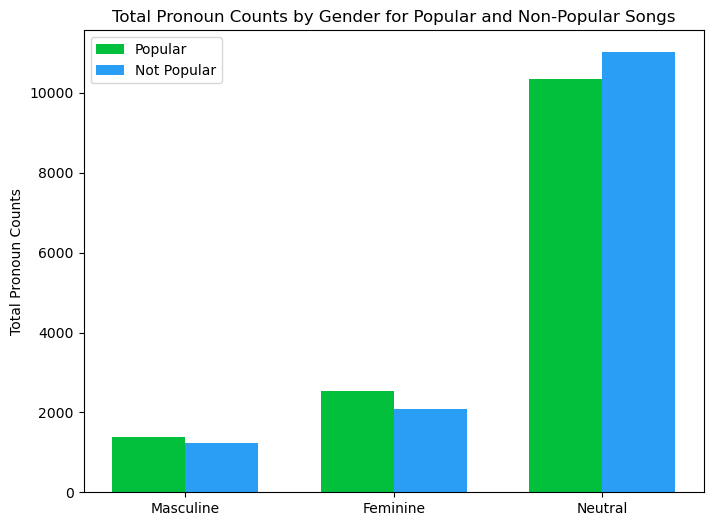

In [475]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(x, totals_popular, width, label='Popular', color='#03C03C')
ax.bar([i + width for i in x], totals_not_popular, width, label='Not Popular', color='#2A9DF4')

ax.set_ylabel('Total Pronoun Counts')
ax.set_title('Total Pronoun Counts by Gender for Popular and Non-Popular Songs')
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()


---

In [390]:
popular_lyrics = ' '.join(df_popular['Lyrics'])
non_popular_lyrics = ' '.join(df_not_popular['Lyrics'])

popular_words = word_tokenize(popular_lyrics)
non_popular_words = word_tokenize(non_popular_lyrics)

popular_ttr = len(set(popular_words)) / len(popular_words)
non_popular_ttr = len(set(non_popular_words)) / len(non_popular_words)

popular_avg_word_length = sum(len(word) for word in popular_words) / len(popular_words)
non_popular_avg_word_length = sum(len(word) for word in non_popular_words) / len(non_popular_words)

print("Type-Token Ratio (TTR) - Popular Songs:", popular_ttr)
print("Type-Token Ratio (TTR) - Non-Popular Songs:", non_popular_ttr)
print("Average Word Length - Popular Songs:", popular_avg_word_length)
print("Average Word Length - Non-Popular Songs:", non_popular_avg_word_length)


Type-Token Ratio (TTR) - Popular Songs: 0.03227609403874138
Type-Token Ratio (TTR) - Non-Popular Songs: 0.033181889467043986
Average Word Length - Popular Songs: 3.69578396668664
Average Word Length - Non-Popular Songs: 3.7312936395916867


---

In [391]:
nltk.download('punkt')
nltk.download('stopwords')

popular_lyrics = ' '.join(df_popular['Lyrics'])
non_popular_lyrics = ' '.join(df_not_popular['Lyrics'])

popular_words = word_tokenize(popular_lyrics.lower())
non_popular_words = word_tokenize(non_popular_lyrics.lower())

stop_words = set(stopwords.words('english'))
popular_words = [word for word in popular_words if word not in stop_words]
non_popular_words = [word for word in non_popular_words if word not in stop_words]

popular_avg_word_length = sum(len(word) for word in popular_words) / len(popular_words)
non_popular_avg_word_length = sum(len(word) for word in non_popular_words) / len(non_popular_words)

popular_word_freq = Counter(popular_words)
non_popular_word_freq = Counter(non_popular_words)

uncommon_words_popular = [word for word, freq in popular_word_freq.items() if freq <= 2]
uncommon_words_non_popular = [word for word, freq in non_popular_word_freq.items() if freq <= 2]

popular_ttr = len(set(popular_words)) / len(popular_words)
non_popular_ttr = len(set(non_popular_words)) / len(non_popular_words)

print("Average Word Length - Popular Songs:", popular_avg_word_length)
print("Average Word Length - Non-Popular Songs:", non_popular_avg_word_length)
print("Frequency of Uncommon Words - Popular Songs:", len(uncommon_words_popular))
print("Frequency of Uncommon Words - Non-Popular Songs:", len(uncommon_words_non_popular))
print("Type-Token Ratio (TTR) - Popular Songs:", popular_ttr)
print("Type-Token Ratio (TTR) - Non-Popular Songs:", non_popular_ttr)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/theobragstad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/theobragstad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Average Word Length - Popular Songs: 4.611899983472245
Average Word Length - Non-Popular Songs: 4.647423944084395
Frequency of Uncommon Words - Popular Songs: 7404
Frequency of Uncommon Words - Non-Popular Songs: 8231
Type-Token Ratio (TTR) - Popular Songs: 0.05988241682997662
Type-Token Ratio (TTR) - Non-Popular Songs: 0.061035986108032216


In [468]:
print("Average Word Length - Popular Songs:", round(popular_avg_word_length, 2))
print("Average Word Length - Non-Popular Songs:", round(non_popular_avg_word_length, 2))
print("Frequency of Uncommon Words - Popular Songs:", round(len(uncommon_words_popular), 2))
print("Frequency of Uncommon Words - Non-Popular Songs:", round(len(uncommon_words_non_popular), 2))
print("Type-Token Ratio (TTR) - Popular Songs:", round(popular_ttr, 2))
print("Type-Token Ratio (TTR) - Non-Popular Songs:", round(non_popular_ttr, 2))


Average Word Length - Popular Songs: 4.61
Average Word Length - Non-Popular Songs: 4.65
Frequency of Uncommon Words - Popular Songs: 7404
Frequency of Uncommon Words - Non-Popular Songs: 8231
Type-Token Ratio (TTR) - Popular Songs: 0.06
Type-Token Ratio (TTR) - Non-Popular Songs: 0.06


---

In [392]:
def extract_rhyme_scheme(lyrics):
    lines = re.split(r'[.!?]', lyrics)  
    rhyme_scheme = []
    for line in lines:
        line = re.sub(r'[^\w\s]', '', line.lower())
        words = line.split()
        if words:
            last_word = words[-1]
            rhyme_part = re.findall(r'[aeiou]+[bcdfghjklmnpqrstvwxyz]*', last_word)
            if rhyme_part:
                rhyme_scheme.append(rhyme_part[-1])
            else:
                rhyme_scheme.append("")  
    return rhyme_scheme

def identify_alliteration(lyrics):
    alliteration_count = 0
    words = re.findall(r'\b\w+\b', lyrics.lower())  
    for i in range(len(words) - 1):
        if words[i] and words[i + 1] and words[i][0] == words[i + 1][0]:
            alliteration_count += 1
    return alliteration_count

popular_lyrics = ' '.join(df_popular['Lyrics'])
non_popular_lyrics = ' '.join(df_not_popular['Lyrics'])

popular_rhyme_scheme = extract_rhyme_scheme(popular_lyrics)
non_popular_rhyme_scheme = extract_rhyme_scheme(non_popular_lyrics)

popular_alliteration_count = identify_alliteration(popular_lyrics)
non_popular_alliteration_count = identify_alliteration(non_popular_lyrics)

popular_rhyme_counts = Counter(popular_rhyme_scheme)
non_popular_rhyme_counts = Counter(non_popular_rhyme_scheme)

print("Rhyme Scheme Counts - Popular Songs:", popular_rhyme_counts)
print("Rhyme Scheme Counts - Non-Popular Songs:", non_popular_rhyme_counts)
print("Alliteration Count - Popular Songs:", popular_alliteration_count)
print("Alliteration Count - Non-Popular Songs:", non_popular_alliteration_count)


Rhyme Scheme Counts - Popular Songs: Counter({'ood': 1})
Rhyme Scheme Counts - Non-Popular Songs: Counter({'e': 1})
Alliteration Count - Popular Songs: 27920
Alliteration Count - Non-Popular Songs: 29429


---

In [395]:
word2vec_model = api.load("word2vec-google-news-300")

def calculate_similarity(word1, word2, model):
    try:
        similarity = model.similarity(word1, word2)
        return similarity
    except KeyError:
        return None

def compare_lyrics(df_popular, df_not_popular, word2vec_model, words_of_interest):
    similarities_popular = []
    similarities_not_popular = []

    for lyrics in df_popular['Lyrics']:
        similarity_sum = 0
        count = 0
        for word in words_of_interest:
            words = lyrics.split()
            for w in words:
                similarity = calculate_similarity(word, w, word2vec_model)
                if similarity is not None:
                    similarity_sum += similarity
                    count += 1
        if count > 0:
            similarities_popular.append(similarity_sum / count)
        else:
            similarities_popular.append(0)

    for lyrics in df_not_popular['Lyrics']:
        similarity_sum = 0
        count = 0
        for word in words_of_interest:
            words = lyrics.split()
            for w in words:
                similarity = calculate_similarity(word, w, word2vec_model)
                if similarity is not None:
                    similarity_sum += similarity
                    count += 1
        if count > 0:
            similarities_not_popular.append(similarity_sum / count)
        else:
            similarities_not_popular.append(0)

    return similarities_popular, similarities_not_popular



[==================================================] 100.0% 1662.8/1662.8MB downloaded
Mean similarity for popular songs: 0.127098298001511
Mean similarity for unpopular songs: 0.12563054295711826


In [396]:
words_of_interest = ['love']

similarities_popular, similarities_not_popular = compare_lyrics(df_popular, df_not_popular, word2vec_model, words_of_interest)

print("Mean similarity for popular songs:", sum(similarities_popular) / len(similarities_popular))
print("Mean similarity for unpopular songs:", sum(similarities_not_popular) / len(similarities_not_popular))


Mean similarity for popular songs: 0.1947770089132641
Mean similarity for unpopular songs: 0.19007805147890247


In [397]:
words_of_interest = ['love', 'happiness', 'sadness', 'anger', 'party', 'friendship', 'loneliness', 'success', 'struggle', 'beautiful', 'dark', 'bright', 'uplifting', 'melancholy']

comparison_results = {}

for word in words_of_interest:
    similarities_popular, similarities_not_popular = compare_lyrics(df_popular, df_not_popular, word2vec_model, [word])
    
    mean_similarity_popular = sum(similarities_popular) / len(similarities_popular)
    
    mean_similarity_not_popular = sum(similarities_not_popular) / len(similarities_not_popular)
    
    comparison_results[word] = {
        'mean_similarity_popular': mean_similarity_popular,
        'mean_similarity_not_popular': mean_similarity_not_popular
    }

for word, result in comparison_results.items():
    print("Word:", word)
    print("Mean similarity for popular songs:", result['mean_similarity_popular'])
    print("Mean similarity for unpopular songs:", result['mean_similarity_not_popular'])
    print()


Word: love
Mean similarity for popular songs: 0.1947770089132641
Mean similarity for unpopular songs: 0.19007805147890247

Word: happiness
Mean similarity for popular songs: 0.10833798661340255
Mean similarity for unpopular songs: 0.10602998209871986

Word: sadness
Mean similarity for popular songs: 0.07600095224566542
Mean similarity for unpopular songs: 0.0743732078095413

Word: anger
Mean similarity for popular songs: 0.08699920238362394
Mean similarity for unpopular songs: 0.08621138945869607

Word: party
Mean similarity for popular songs: 0.0844779266538674
Mean similarity for unpopular songs: 0.08381189686408458

Word: friendship
Mean similarity for popular songs: 0.07766757841690014
Mean similarity for unpopular songs: 0.0761442789991343

Word: loneliness
Mean similarity for popular songs: 0.09746845546656595
Mean similarity for unpopular songs: 0.09573816506255393

Word: success
Mean similarity for popular songs: 0.07935798538305981
Mean similarity for unpopular songs: 0.080170

In [480]:
print("Mean similarities to words:")
print()
for word, result in comparison_results.items():
    print("Word:", word)
    print("Popular:", round(result['mean_similarity_popular'], 2))
    print("Not Popular:", round(result['mean_similarity_not_popular'], 2))
    print()

Mean similarities to words:

Word: love
Popular: 0.19
Not Popular: 0.19

Word: happiness
Popular: 0.11
Not Popular: 0.11

Word: sadness
Popular: 0.08
Not Popular: 0.07

Word: anger
Popular: 0.09
Not Popular: 0.09

Word: party
Popular: 0.08
Not Popular: 0.08

Word: friendship
Popular: 0.08
Not Popular: 0.08

Word: loneliness
Popular: 0.1
Not Popular: 0.1

Word: success
Popular: 0.08
Not Popular: 0.08

Word: struggle
Popular: 0.11
Not Popular: 0.11

Word: beautiful
Popular: 0.16
Not Popular: 0.15

Word: dark
Popular: 0.12
Not Popular: 0.12

Word: bright
Popular: 0.09
Not Popular: 0.09

Word: uplifting
Popular: 0.09
Not Popular: 0.09

Word: melancholy
Popular: 0.08
Not Popular: 0.08



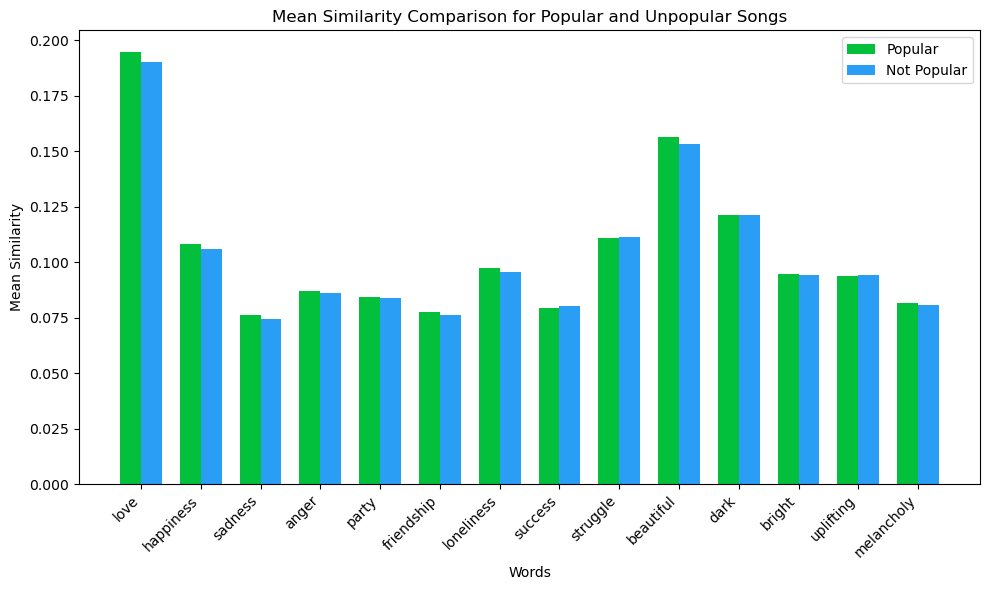

In [510]:
words = list(comparison_results.keys())
mean_similarities_popular = [result['mean_similarity_popular'] for result in comparison_results.values()]
mean_similarities_not_popular = [result['mean_similarity_not_popular'] for result in comparison_results.values()]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(words))
plt.bar(index, mean_similarities_popular, bar_width, label='Popular', color='#03c03c')
plt.bar([i + bar_width for i in index], mean_similarities_not_popular, bar_width, label='Not Popular', color='#2A9DF4')
plt.xlabel('Words')
plt.ylabel('Mean Similarity')
plt.title('Mean Similarity Comparison for Popular and Unpopular Songs')
plt.xticks([i + bar_width / 2 for i in index], words, rotation=45, ha='right')  
plt.legend()
plt.tight_layout()
plt.show()

---

In [400]:

nlp = spacy.load("en_core_web_sm")

def extract_named_entities(lyrics):
    doc = nlp(lyrics)
    named_entities = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['PERSON', 'ORG', 'GPE', 'TIME', 'MONEY', 'PRODUCT', 'EVENT']]
    return named_entities


df_popular['named_entities'] = df_popular['Lyrics'].apply(extract_named_entities)

df_not_popular['named_entities'] = df_not_popular['Lyrics'].apply(extract_named_entities)

print("Named entities in popular songs:")
print(df_popular['named_entities'])

print("\nNamed entities in unpopular songs:")
print(df_not_popular['named_entities'])


/var/folders/lg/dk9tt69935gcdz1c_wb40mnr0000gn/T/ipykernel_88269/42886900.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popular['named_entities'] = df_popular['Lyrics'].apply(extract_named_entities)


Named entities in popular songs:
0                                                      []
1       [(mm, PERSON), (fallin, PERSON), (last night, ...
2                                                      []
3                                                      []
4                                                      []
                              ...                        
1913                                                   []
1915                                                   []
1916                                                   []
1917    [(america, GPE), (america, GPE), (america, GPE...
1918                                                   []
Name: named_entities, Length: 1715, dtype: object

Named entities in unpopular songs:
2375     [(s happenin silky, PERSON), (marvin, PERSON),...
14019    [(nigga, PERSON), (nigga, PERSON), (cadillac, ...
13426                                      [(london, GPE)]
14464    [(ya oooh, PERSON), (ya oooh, PERSON), (ya ooo...
4296   

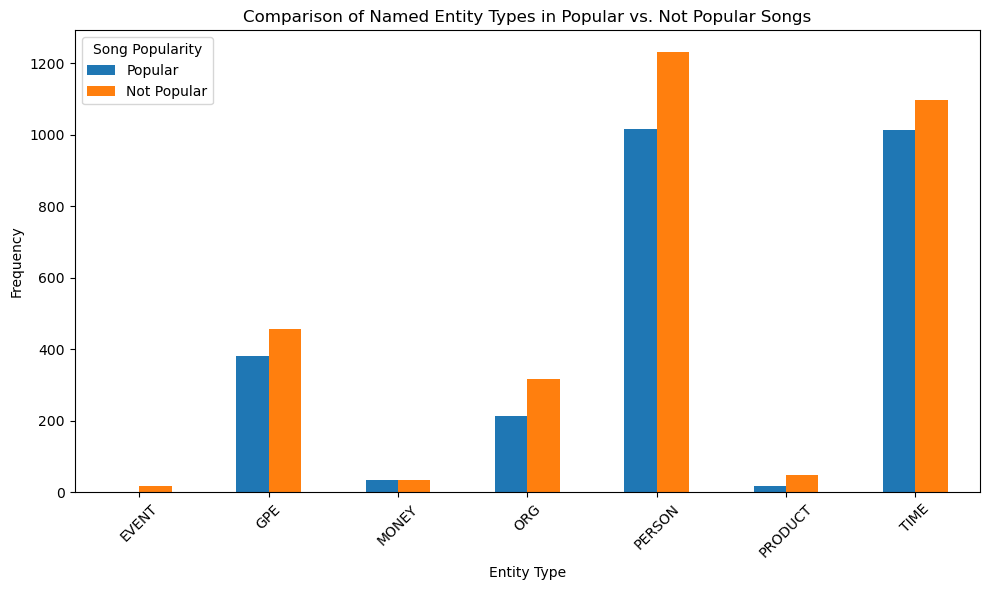

In [511]:


popular_entities = [entity for entities_list in df_popular['named_entities'] for entity in entities_list]
popular_entity_types = [entity[1] for entity in popular_entities]
popular_entity_counts = pd.Series(popular_entity_types).value_counts()

not_popular_entities = [entity for entities_list in df_not_popular['named_entities'] for entity in entities_list]
not_popular_entity_types = [entity[1] for entity in not_popular_entities]
not_popular_entity_counts = pd.Series(not_popular_entity_types).value_counts()

entity_counts = pd.DataFrame({
    'Popular': popular_entity_counts,
    'Not Popular': not_popular_entity_counts
}).fillna(0)

entity_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Comparison of Named Entity Types in Popular vs. Not Popular Songs')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Song Popularity')
plt.tight_layout()
plt.show()


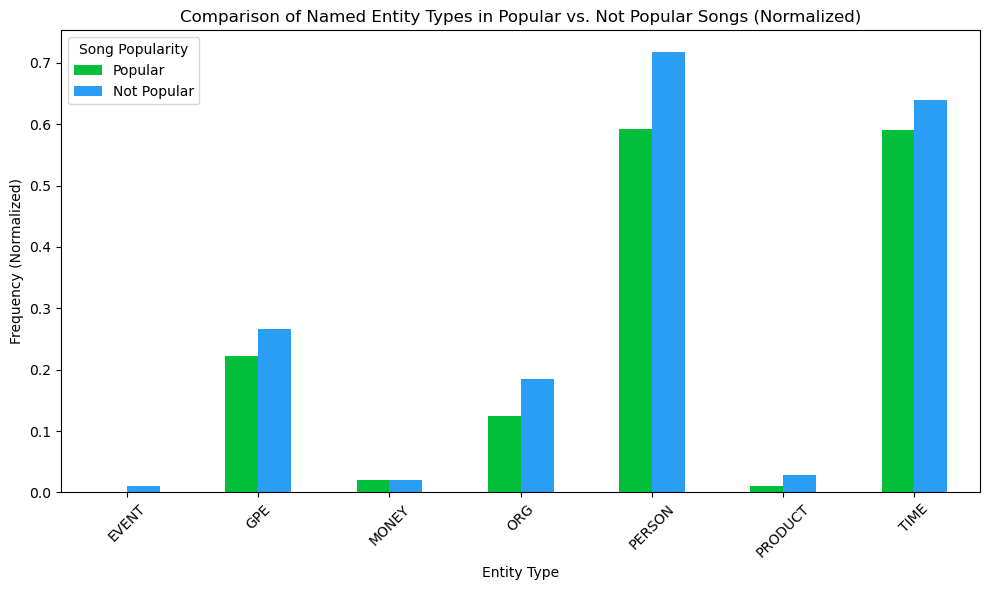

In [514]:


popular_entities = [entity for entities_list in df_popular['named_entities'] for entity in entities_list]
popular_entity_types = [entity[1] for entity in popular_entities]
popular_entity_counts = pd.Series(popular_entity_types).value_counts()

not_popular_entities = [entity for entities_list in df_not_popular['named_entities'] for entity in entities_list]
not_popular_entity_types = [entity[1] for entity in not_popular_entities]
not_popular_entity_counts = pd.Series(not_popular_entity_types).value_counts()

total_popular_songs = len(df_popular)
total_not_popular_songs = len(df_not_popular)

popular_entity_counts_normalized = popular_entity_counts / total_popular_songs
not_popular_entity_counts_normalized = not_popular_entity_counts / total_not_popular_songs

entity_counts_normalized = pd.DataFrame({
    'Popular': popular_entity_counts_normalized,
    'Not Popular': not_popular_entity_counts_normalized
}).fillna(0)

entity_counts_normalized.plot(kind='bar', figsize=(10, 6), color=['#03c03c', '#2A9DF4'])
plt.title('Comparison of Named Entity Types in Popular vs. Not Popular Songs (Normalized)')
plt.xlabel('Entity Type')
plt.ylabel('Frequency (Normalized)')
plt.xticks(rotation=45)
plt.legend(title='Song Popularity')
plt.tight_layout()
plt.show()


In [405]:
df_popular['named_entities'].iloc[14]

[('california', 'GPE'), ('the minute', 'TIME')]

---

In [406]:


def preprocess_lyrics(lyrics):
    return preprocess_string(lyrics)

df_popular['preprocessed_lyrics'] = df_popular['Lyrics'].apply(preprocess_lyrics)
df_not_popular['preprocessed_lyrics'] = df_not_popular['Lyrics'].apply(preprocess_lyrics)

dictionary_popular = corpora.Dictionary(df_popular['preprocessed_lyrics'])
corpus_popular = [dictionary_popular.doc2bow(text) for text in df_popular['preprocessed_lyrics']]

lda_model_popular = LdaModel(corpus=corpus_popular, id2word=dictionary_popular, num_topics=5)

print("Topics for popular songs:")
for idx, topic in lda_model_popular.print_topics():
    print(f"Topic {idx}: {topic}")

dictionary_unpopular = corpora.Dictionary(df_not_popular['preprocessed_lyrics'])
corpus_unpopular = [dictionary_unpopular.doc2bow(text) for text in df_not_popular['preprocessed_lyrics']]

lda_model_unpopular = LdaModel(corpus=corpus_unpopular, id2word=dictionary_unpopular, num_topics=5)

print("\nTopics for unpopular songs:")
for idx, topic in lda_model_unpopular.print_topics():
    print(f"Topic {idx}: {topic}")


/var/folders/lg/dk9tt69935gcdz1c_wb40mnr0000gn/T/ipykernel_88269/2518723081.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popular['preprocessed_lyrics'] = df_popular['Lyrics'].apply(preprocess_lyrics)


Topics for popular songs:
Topic 0: 0.010*"come" + 0.010*"got" + 0.009*"know" + 0.009*"dont" + 0.009*"feel" + 0.008*"your" + 0.007*"time" + 0.007*"caus" + 0.007*"wai" + 0.007*"like"
Topic 1: 0.022*"dont" + 0.016*"love" + 0.012*"know" + 0.012*"like" + 0.010*"feel" + 0.010*"got" + 0.009*"come" + 0.009*"want" + 0.008*"let" + 0.008*"yeah"
Topic 2: 0.021*"like" + 0.020*"yeah" + 0.019*"know" + 0.016*"got" + 0.016*"dont" + 0.012*"come" + 0.011*"babi" + 0.009*"love" + 0.008*"let" + 0.008*"caus"
Topic 3: 0.030*"love" + 0.022*"know" + 0.017*"like" + 0.016*"ooh" + 0.014*"your" + 0.011*"feel" + 0.011*"time" + 0.011*"dont" + 0.010*"got" + 0.009*"want"
Topic 4: 0.024*"dont" + 0.023*"like" + 0.017*"know" + 0.016*"yeah" + 0.014*"love" + 0.013*"got" + 0.012*"wanna" + 0.011*"babi" + 0.011*"let" + 0.011*"want"

Topics for unpopular songs:
Topic 0: 0.028*"love" + 0.020*"know" + 0.016*"your" + 0.015*"feel" + 0.012*"come" + 0.011*"dont" + 0.009*"let" + 0.007*"got" + 0.007*"wai" + 0.007*"right"
Topic 1: 0.023

---

## Lyrical diversity (repetitiveness)

In [412]:


def clean_and_tokenize(lyrics):
    stop_words = set(stopwords.words('english'))
    porter = PorterStemmer()
    
    tokens = word_tokenize(lyrics.lower())  
    tokens = [porter.stem(token) for token in tokens if token.isalnum() and token not in stop_words]  
    
    return tokens

def calculate_diversity(lyrics):
    tokens = clean_and_tokenize(lyrics)
    total_words = len(tokens)
    unique_words = len(set(tokens))
    if total_words == 0:
        return 0
    else:
        return unique_words / total_words

df_popular['Diversity'] = df_popular['Lyrics'].apply(calculate_diversity)
df_not_popular['Diversity'] = df_not_popular['Lyrics'].apply(calculate_diversity)

pop_mean_diversity = df_popular['Diversity'].mean()
nonpop_mean_diversity = df_not_popular['Diversity'].mean()

print("Mean Diversity - Pop Songs:", pop_mean_diversity)
print("Mean Diversity - Non-Pop Songs:", nonpop_mean_diversity)


t_stat, p_value = ttest_ind(df_popular['Diversity'], df_not_popular['Diversity'])
print("T-statistic:", t_stat)
print("P-value:", p_value)

/var/folders/lg/dk9tt69935gcdz1c_wb40mnr0000gn/T/ipykernel_88269/4279689939.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popular['Diversity'] = df_popular['Lyrics'].apply(calculate_diversity)


Mean Diversity - Pop Songs: 0.5564829849579602
Mean Diversity - Non-Pop Songs: 0.513984430185766
T-statistic: 6.570958824712221
P-value: 5.7563897477679394e-11


In [487]:
print("Mean Diversity - Popular Songs:", round(pop_mean_diversity, 2))
print("Mean Diversity - Not Popular Songs:", round(nonpop_mean_diversity, 2))


Mean Diversity - Popular Songs: 0.56
Mean Diversity - Not Popular Songs: 0.51


In [421]:
sorted_popular_songs = df_popular.sort_values(by='Diversity', ascending=True)

sorted_non_popular_songs = df_not_popular.sort_values(by='Diversity', ascending=True)




In [422]:
sorted_popular_songs

Title                    Artist  \
1314           One More Time                 Daft Punk   
1335                 Tuesday               Burak Yeter   
1698                    NUMB              XXXTENTACION   
646      Killing In The Name  Rage Against The Machine   
1539      Turn Down for What                  DJ Snake   
...                      ...                       ...   
236                24K Magic                Bruno Mars   
196                Anti-Hero              Taylor Swift   
755             Stick Season                Noah Kahan   
468               Like Crazy                     Jimin   
847   When It Rains It Pours                Luke Combs   

                                                 Lyrics     Streams  \
1314  one more time one more time one more time we a...   591194117   
1335  got the club going up on a tuesday got your gi...   586551631   
1698  and every single year im drowning in my tears ...   500752937   
646   killing in the name of some of those that work...   879660738   
1539  fire up that loud another round of shots turn ...   539633770   
...                                                 ...         ...   
236   tonight i just wanna take you higher throw you...  1387571349   
196   i have this thing where i get older but just n...  1500659489   
755   as you promised me that i was more than all th...   807027539   
468   i think we could last forever im afraid that e...  1030401109   
847   sunday morning man she woke up fightin mad bit...   761807817   

                                                 Tokens  \
1314  [one, time, one, time, one, time, gon, na, cel...   
1335  [got, club, going, tuesday, got, girl, cut, ai...   
1698  [every, single, year, im, drowning, tears, im,...   
646   [killing, name, work, forces, burn, crosses, w...   
1539  [fire, loud, another, round, shots, turn, turn...   
...                                                 ...   
236   [tonight, wan, na, take, higher, throw, hands,...   
196   [thing, get, older, never, wiser, midnights, b...   
755   [promised, miles, combined, mustve, change, he...   
468   [think, could, last, forever, im, afraid, ever...   
847   [sunday, morning, man, woke, fightin, mad, bit...   

                                         named_entities  \
1314                   [(feelin, GPE), (tonight, TIME)]   
1335                                                 []   
1698                                                 []   
646                                                  []   
1539                                                 []   
...                                                 ...   
236                                   [(tonight, TIME)]   
196                                                  []   
755                                    [(vermont, GPE)]   
468   [(tonight, TIME), (적셔 밤새도록 아침도 취해서 오지 않게 시끄러운 ...   
847             [(sunday morning, TIME), (panama, GPE)]   

                                    preprocessed_lyrics  Diversity  
1314  [time, time, time, gonna, celebr, yeah, right,...   0.096429  
1335  [got, club, go, tuesdai, got, girl, cut, aint,...   0.102273  
1698  [singl, year, drown, tear, drown, tear, forget...   0.132075  
646   [kill, work, forc, burn, cross, work, forc, bu...   0.142857  
1539  [loud, round, shot, turn, turn, turn, turn, tu...   0.146341  
...                                                 ...        ...  
236   [tonight, wanna, higher, throw, hand, sky, let...   0.932203  
196   [thing, older, wiser, midnight, afternoon, dep...   0.933333  
755   [promis, mile, combin, mustv, chang, heart, li...   0.941176  
468   [think, forev, afraid, disappear, trust, she, ...   0.945455  
847   [sundai, morn, man, woke, fightin, mad, bitchi...   0.968750  

[1715 rows x 8 columns]

In [504]:
sorted_non_popular_songs.iloc[-200:-42]


Title           Artist  \
13446                          Movement       Jamie Woon   
15284                    New Jack Swing  Wreckx-N-Effect   
9527               Drop The Bomb On 'Em           Eminem   
683                    Harsh Generation          Grendel   
3463            Save It For The Bedroom    You Me At Six   
...                                 ...              ...   
8099                                Her              Guy   
5684   Wide Awake - Chris Howland Remix      Joel Vaughn   
5965                               Down        blink-182   
5505                        Black Betty   Caravan Palace   
8603                         To the Max        DJ Khaled   

                                                  Lyrics  Popularity  \
13446  is it the way it is or the way it isnt right d...           0   
15284  yo wreckx n effect in full effect 1 2 3 i made...           0   
9527   yeah boy them better ring the alarm boy them k...           0   
683    synthetic systems merging hybrids new technolo...           0   
3463   keep your hands to yourself these lips belong ...           0   
...                                                  ...         ...   
8099   it hasnt been the best of days since she drove...           0   
5684   cant fix a bullet with a bandaid you can try t...           0   
5965   the drops of rain they fall all over this awkw...           0   
5505                                    whoa black betty           2   
8603                               dj khaled another one           0   

                                                  Tokens  \
13446  [way, way, isnt, right, ever, arrive, way, get...   
15284  [yo, wreckx, n, effect, full, effect, 1, 2, 3,...   
9527   [yeah, boy, better, ring, alarm, boy, know, wh...   
683    [synthetic, systems, merging, hybrids, new, te...   
3463   [keep, hands, lips, belong, someone, else, kno...   
...                                                  ...   
8099   [hasnt, best, days, since, drove, left, standi...   
5684   [cant, fix, bullet, bandaid, try, hide, hearts...   
5965   [drops, rain, fall, awkward, silence, makes, c...   
5505                                [whoa, black, betty]   
8603                          [dj, khaled, another, one]   

                                          named_entities  \
13446                                  [(tonight, TIME)]   
15284  [(dee, ORG), (bobby brown, PERSON), (george ja...   
9527   [(god fuckin bumbaclot, PERSON), (tom sawyer, ...   
683                                                   []   
3463                             [(another night, TIME)]   
...                                                  ...   
8099                                                  []   
5684                                                  []   
5965                                                  []   
5505                                                  []   
8603                                                  []   

                                     preprocessed_lyrics  Diversity  
13446  [wai, wai, isnt, right, arriv, wai, water, tas...   0.774194  
15284  [wreckx, effect, effect, new, jack, swing, ye,...   0.775510  
9527   [yeah, boi, better, ring, alarm, boi, know, wh...   0.775862  
683    [synthet, system, merg, hybrid, new, technolog...   0.776119  
3463   [hand, lip, belong, know, li, lie, heard, know...   0.777778  
...                                                  ...        ...  
8099   [best, dai, drove, left, stand, haze, iv, orde...   0.960000  
5684   [fix, bullet, bandaid, try, hide, heart, bleed...   0.964286  
5965   [drop, rain, fall, awkward, silenc, make, craz...   0.966667  
5505                                [whoa, black, betti]   1.000000  
8603                                             [khale]   1.000000  

[158 rows x 8 columns]

In [507]:
sorted_non_popular_songs[sorted_non_popular_songs['Title'] == 'Down']['Lyrics']

5965    the drops of rain they fall all over this awkw...
Name: Lyrics, dtype: object

In [508]:
down_lyrics = sorted_non_popular_songs.loc[sorted_non_popular_songs['Title'] == 'Down', 'Lyrics']
print(down_lyrics.iloc[0]) 


the drops of rain they fall all over this awkward silence makes me crazy the glow inside burns light upon her ill try to kiss you if you let me tidal waves they rip right through me tears from eyes worn cold and sad pick me up now i need you so bad down down down down down down down down down down down down down down down down it gets me so down down down down down down down down down down down down down down down down it gets me so


In [494]:
sorted_non_popular_songs[-100:]

Title        Artist  \
16227                   Python         Healy   
9032             Buss Yo' Head    Young Buck   
3216            Ain't No Nigga         JAY-Z   
8968                 Jasey Rae  All Time Low   
5560                 Caught Up       Ja Rule   
...                        ...           ...   
1893          Piece Of My Love           Guy   
17099             Buried Alive         Logic   
6043                     Lotto        Rotimi   
13310  I'm Real - Murder Remix       Ja Rule   
4611               Ur Highness        IAMDDB   

                                                  Lyrics  Popularity  \
16227  got these past lives in the back of my mind tr...           0   
9032   aight rap niggas well this might be my last ca...           0   
3216   na fox brown yeah jay z what i keep it fresher...           0   
8968   lights out i still hear the rain these images ...           0   
5560   word to mother my nigga buck 3000 on the board...           1   
...                                                  ...         ...   
1893                                       i do love you           0   
17099  tell me how you feel out kast a tribe called q...           1   
6043                                i just hit the lotto           0   
13310                           im real k with your baby           1   
4611   hello hi i might just get friendly with you pe...           0   

                                                  Tokens  \
16227  [got, past, lives, back, mind, tryna, ride, fi...   
9032   [aight, rap, niggas, well, might, last, cause,...   
3216   [na, fox, brown, yeah, jay, z, keep, fresher, ...   
8968   [lights, still, hear, rain, images, fill, head...   
5560   [word, mother, nigga, buck, 3000, boards, holl...   
...                                                  ...   
1893                                              [love]   
17099  [tell, feel, kast, tribe, called, quest, red, ...   
6043                                        [hit, lotto]   
13310                                [im, real, k, baby]   
4611          [hello, hi, might, get, friendly, perfect]   

                                          named_entities  \
16227  [(every night, TIME), (tennessee, GPE), (new o...   
9032                                                  []   
3216     [(50 cent, MONEY), (less than 8 seconds, TIME)]   
8968                                                  []   
5560                                                  []   
...                                                  ...   
1893                                                  []   
17099                                                 []   
6043                                                  []   
13310                                                 []   
4611                                                  []   

                                     preprocessed_lyrics  Diversity  
16227  [got, past, live, mind, tryna, ride, fine, lin...   0.862069  
9032   [aight, rap, nigga, caus, imma, set, blast, li...   0.862745  
3216   [fox, brown, yeah, jai, fresher, bitch, need, ...   0.866667  
8968   [light, hear, rain, imag, head, finger, make, ...   0.866667  
5560   [word, mother, nigga, buck, board, holla, hei,...   0.868421  
...                                                  ...        ...  
1893                                              [love]   1.000000  
17099  [tell, feel, kast, tribe, call, quest, red, ho...   1.000000  
6043                                        [hit, lotto]   1.000000  
13310                                       [real, babi]   1.000000  
4611                          [hello, friendli, perfect]   1.000000  

[100 rows x 8 columns]